In [1]:
import pandas as pd
import numpy as np
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile, os
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
#Getting Data
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! pip install --upgrade kaggle
! kaggle datasets download -d camnugent/california-housing-prices

Saving kaggle.json to kaggle.json
Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.9)
  0% 0.00/400k [00:00<?, ?B/s]
100% 400k/400k [00:00<00:00, 54.3MB/s]


In [3]:
#Extract Data
local_zip = '/content/california-housing-prices.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [7]:
df = pd.read_csv('/tmp/housing.csv')
print(df['ocean_proximity'].unique())
print(df.describe())

['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']
          longitude      latitude  ...  median_income  median_house_value
count  20640.000000  20640.000000  ...   20640.000000        20640.000000
mean    -119.569704     35.631861  ...       3.870671       206855.816909
std        2.003532      2.135952  ...       1.899822       115395.615874
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%     -121.800000     33.930000  ...       2.563400       119600.000000
50%     -118.490000     34.260000  ...       3.534800       179700.000000
75%     -118.010000     37.710000  ...       4.743250       264725.000000
max     -114.310000     41.950000  ...      15.000100       500001.000000

[8 rows x 9 columns]


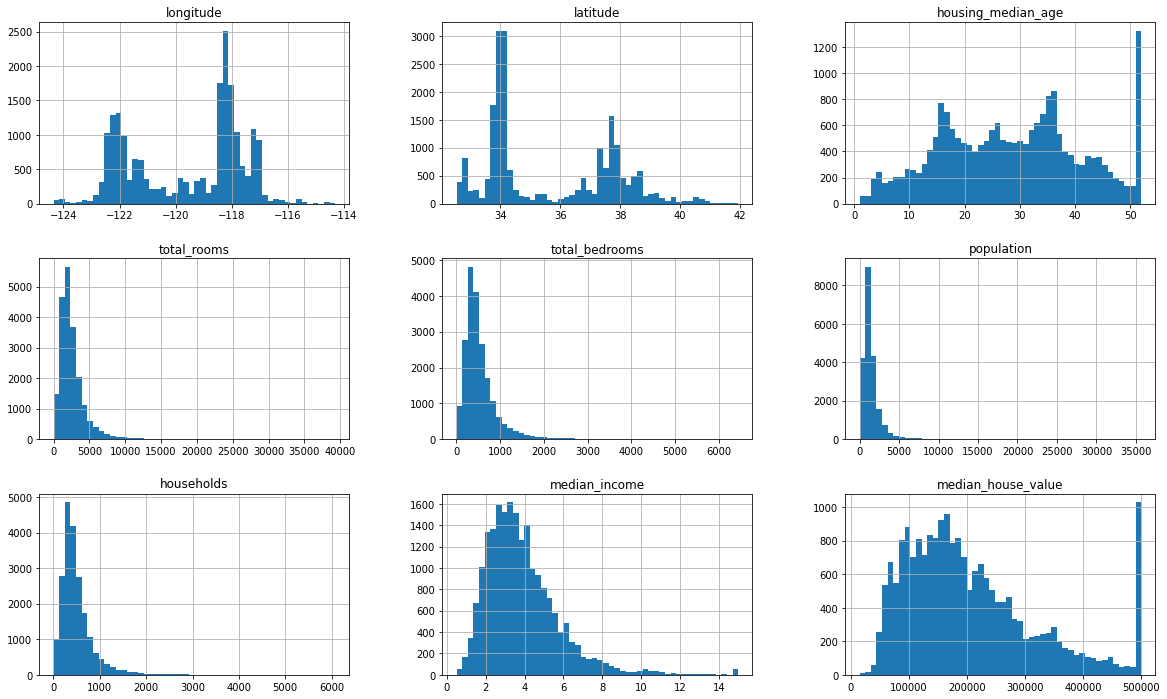

In [8]:
df.hist(bins=50,figsize=(20,12))
plt.show()

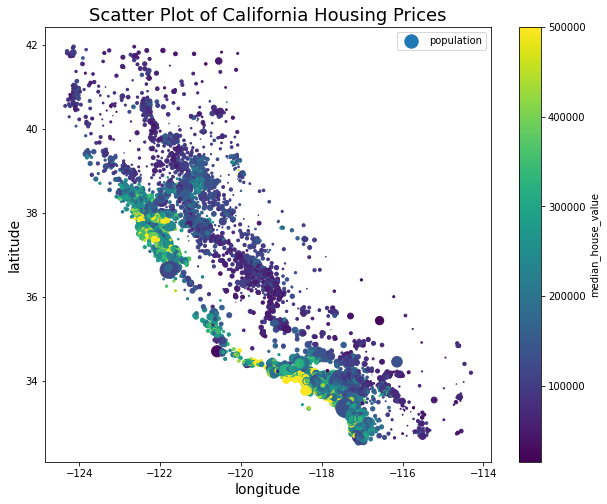

In [9]:
plt.figure(figsize=(10,8))
plt.scatter(df['longitude'],df['latitude'],s=df['population']/100,label='population',c=df['median_house_value'])
plt.colorbar(label='median_house_value')
plt.xlabel('longitude',fontsize=14)
plt.ylabel('latitude',fontsize=14)
plt.title('Scatter Plot of California Housing Prices',fontsize=18)
plt.legend()
plt.show()

In [10]:
#Check Correlation
print(df.corr()['median_house_value'].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


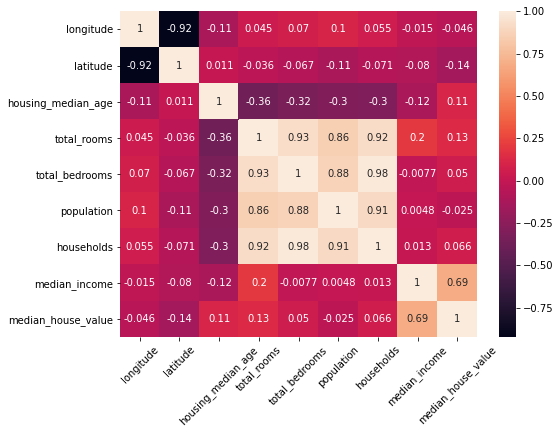

In [11]:
f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df.corr(),annot=True,ax=ax)
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Boxplot of total_bedrooms')

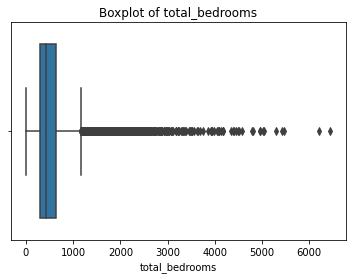

In [12]:
sns.boxplot(df['total_bedrooms'])
plt.title('Boxplot of total_bedrooms')

In [13]:
df['total_bedrooms'].fillna(df['total_bedrooms'].median(),inplace=True)
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [14]:
encoder = OneHotEncoder(sparse=False,handle_unknown='error',drop='first')
df_onehotencoder = pd.DataFrame(encoder.fit_transform(df[['ocean_proximity']]))
encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [15]:
df = df.join(df_onehotencoder)

In [16]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,0,1,2,3
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,0.0,0.0,1.0,0.0


In [17]:
df = df.drop(columns='ocean_proximity')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,0,1,2,3
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,1.0,0.0


In [18]:
X = df.drop('median_house_value',axis=1)
y = df['median_house_value']
print(X.shape)
print(y.shape)

(20640, 12)
(20640,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=100)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16512, 12)
(4128, 12)
(16512,)
(4128,)


In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [21]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [23]:
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2: ',r2_score(y_test, y_pred)) 

RMSE:  67150.8850843364
R2:  0.6653369043936411


In [24]:
Rf = RandomForestRegressor()
Rf.fit(X_train,y_train)
y_pred_rf = Rf.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print('R2: ',r2_score(y_test, y_pred_rf))

RMSE:  53193.03720786683
R2:  0.7900025998685154


In [25]:
Dt = DecisionTreeRegressor()
Dt.fit(X_train,y_train)
y_pred_dt = Dt.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_dt)))
print('R2: ',r2_score(y_test, y_pred_dt))

RMSE:  76958.35865776372
R2:  0.5604422570862884


In [26]:
ridge = Ridge()
ridge.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('R2: ',r2_score(y_test, y_pred_ridge))

RMSE:  67151.59736114986
R2:  0.6653298047395637
